# Etudes des données textuelles

Pour commencer, nous allons procéder à une étude des données textuelles présentes dans les différentes annonces. L'objectif n'est ici pas de classer les images grâce à ces informations mais bien d'étudier la faisabilité de cette entreprise.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk 
from nltk.tokenize import word_tokenize
#nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
#nltk.download('omw-1.4')
#nltk.download('wordnet')

from nltk.corpus import stopwords
#nltk.download('stopwords')

In [2]:
#On importe le jeu de données
sample = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
sample.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
sample.product_name

0       Elegance Polyester Multicolor Abstract Eyelet ...
1                              Sathiyas Cotton Bath Towel
2                     Eurospa Cotton Terry Face Towel Set
3       SANTOSH ROYAL FASHION Cotton Printed King size...
4       Jaipur Print Cotton Floral King sized Double B...
                              ...                        
1045       Oren Empower Extra Large Self Adhesive Sticker
1046               Wallmantra Large Vinyl Sticker Sticker
1047    Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048              Wallmantra Medium Vinyl Sticker Sticker
1049                         Uberlyfe Large Vinyl Sticker
Name: product_name, Length: 1050, dtype: object

Pour chaque annonce on a de nombreuses features, mais ici tout ne va pas nous intéresser. En effet, comme on souhaite se concentrer dans un premier temps sur les données textuelles, on va seulement regarder les features *product_name* et *description*.

# Extraction des features texte

## 1ère approche : Bag of words

### Count & Tf-idf

Dans une première approche, on va commencer en utilisant des méthodes assez simples de comptage de mots pour regrouper les différents articles mis en vente. Avant cela, il est cependant nécessaire d'appliquer un traitement sur nos données.

In [5]:
# Les seules variables qui nous intéressent pour le moment sont la description et le nom du produit
texts = sample[['product_name','description']]

#On commence par retirer tous les caractères de ponctuation ou spéciaux
def normalization(data) :
    for col in data.columns :
        data[col] = data[col].apply(lambda x : re.sub(r"[^a-zA-Z0-9]"," ", x))    
    return data

#Puis on passe les mots en minuscules
def tolower(data) :
    for col in data.columns :
        data[col] = data[col].apply(lambda x : x.lower())
    return data

# On tokenize maintenant en mots
def tokenization(data) : 
    for col in data.columns :
        data[col] = data[col].apply(lambda x : word_tokenize(x))
    return data
    
# On supprime les stop words
stop_w = set(stopwords.words('english'))
def nostopwords(data) : 
    for col in data.columns:
        data[col] = data[col].apply(lambda lst : [word for word in lst if word not in stop_w])
    return data

# On lemmatise les mots
def lemmatization(data) :
        for col in data.columns:
            data[col] = data[col].apply(lambda lst: [lemmatizer.lemmatize(word) for word in lst])
        return data

In [6]:
normalization(texts)

C:\Users\Helios\AppData\Local\Temp\ipykernel_24148\567115392.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda x : re.sub(r"[^a-zA-Z0-9]"," ", x))


,product_name,description
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel ...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...
...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker Pack o...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...


In [7]:
tolower(texts)

C:\Users\Helios\AppData\Local\Temp\ipykernel_24148\567115392.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda x : x.lower())


,product_name,description
0,elegance polyester multicolor abstract eyelet ...,key features of elegance polyester multicolor ...
1,sathiyas cotton bath towel,specifications of sathiyas cotton bath towel ...
2,eurospa cotton terry face towel set,key features of eurospa cotton terry face towe...
3,santosh royal fashion cotton printed king size...,key features of santosh royal fashion cotton p...
4,jaipur print cotton floral king sized double b...,key features of jaipur print cotton floral kin...
...,...,...
1045,oren empower extra large self adhesive sticker,oren empower extra large self adhesive sticker...
1046,wallmantra large vinyl sticker sticker,wallmantra large vinyl sticker sticker pack o...
1047,uberlyfe extra large pigmented polyvinyl films...,buy uberlyfe extra large pigmented polyvinyl f...
1048,wallmantra medium vinyl sticker sticker,buy wallmantra medium vinyl sticker sticker fo...


On a maintenant formaté nos deux variables afin de ne pas être dérangé par la ponctuation ou la capitalisation. On va maintenant tokeniser les variables afin de les séparer mot par mot.

In [8]:
tokenization(texts)

C:\Users\Helios\AppData\Local\Temp\ipykernel_24148\567115392.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda x : word_tokenize(x))


,product_name,description
0,"[elegance, polyester, multicolor, abstract, ey...","[key, features, of, elegance, polyester, multi..."
1,"[sathiyas, cotton, bath, towel]","[specifications, of, sathiyas, cotton, bath, t..."
2,"[eurospa, cotton, terry, face, towel, set]","[key, features, of, eurospa, cotton, terry, fa..."
3,"[santosh, royal, fashion, cotton, printed, kin...","[key, features, of, santosh, royal, fashion, c..."
4,"[jaipur, print, cotton, floral, king, sized, d...","[key, features, of, jaipur, print, cotton, flo..."
...,...,...
1045,"[oren, empower, extra, large, self, adhesive, ...","[oren, empower, extra, large, self, adhesive, ..."
1046,"[wallmantra, large, vinyl, sticker, sticker]","[wallmantra, large, vinyl, sticker, sticker, p..."
1047,"[uberlyfe, extra, large, pigmented, polyvinyl,...","[buy, uberlyfe, extra, large, pigmented, polyv..."
1048,"[wallmantra, medium, vinyl, sticker, sticker]","[buy, wallmantra, medium, vinyl, sticker, stic..."


In [9]:
nostopwords(texts)

C:\Users\Helios\AppData\Local\Temp\ipykernel_24148\567115392.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda lst : [word for word in lst if word not in stop_w])


,product_name,description
0,"[elegance, polyester, multicolor, abstract, ey...","[key, features, elegance, polyester, multicolo..."
1,"[sathiyas, cotton, bath, towel]","[specifications, sathiyas, cotton, bath, towel..."
2,"[eurospa, cotton, terry, face, towel, set]","[key, features, eurospa, cotton, terry, face, ..."
3,"[santosh, royal, fashion, cotton, printed, kin...","[key, features, santosh, royal, fashion, cotto..."
4,"[jaipur, print, cotton, floral, king, sized, d...","[key, features, jaipur, print, cotton, floral,..."
...,...,...
1045,"[oren, empower, extra, large, self, adhesive, ...","[oren, empower, extra, large, self, adhesive, ..."
1046,"[wallmantra, large, vinyl, sticker, sticker]","[wallmantra, large, vinyl, sticker, sticker, p..."
1047,"[uberlyfe, extra, large, pigmented, polyvinyl,...","[buy, uberlyfe, extra, large, pigmented, polyv..."
1048,"[wallmantra, medium, vinyl, sticker, sticker]","[buy, wallmantra, medium, vinyl, sticker, stic..."


Maintenant qu'on a pu séparer les mots, on va les lemmatiser afin d'obtenir la version la plus simple du mot, ce qui permettra de les simplifier et qui facilitera l'identification de mots clés pour nos algorithmes, et qui premttra de regrouper ensemble des mots similaires lors du comptage.

In [10]:
lemmatizer = WordNetLemmatizer()

print('rocks : ',lemmatizer.lemmatize('rocks'))

rocks :  rock


In [11]:
lemmatization(texts)

C:\Users\Helios\AppData\Local\Temp\ipykernel_24148\567115392.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].apply(lambda lst: [lemmatizer.lemmatize(word) for word in lst])


,product_name,description
0,"[elegance, polyester, multicolor, abstract, ey...","[key, feature, elegance, polyester, multicolor..."
1,"[sathiyas, cotton, bath, towel]","[specification, sathiyas, cotton, bath, towel,..."
2,"[eurospa, cotton, terry, face, towel, set]","[key, feature, eurospa, cotton, terry, face, t..."
3,"[santosh, royal, fashion, cotton, printed, kin...","[key, feature, santosh, royal, fashion, cotton..."
4,"[jaipur, print, cotton, floral, king, sized, d...","[key, feature, jaipur, print, cotton, floral, ..."
...,...,...
1045,"[oren, empower, extra, large, self, adhesive, ...","[oren, empower, extra, large, self, adhesive, ..."
1046,"[wallmantra, large, vinyl, sticker, sticker]","[wallmantra, large, vinyl, sticker, sticker, p..."
1047,"[uberlyfe, extra, large, pigmented, polyvinyl,...","[buy, uberlyfe, extra, large, pigmented, polyv..."
1048,"[wallmantra, medium, vinyl, sticker, sticker]","[buy, wallmantra, medium, vinyl, sticker, stic..."


Maintenant qu'on a tokenisé et lemmatisé nos textes, on va pouvoir passer à l'analyse. Pour cela on va commencer par une approche bag of words simple, avec un CountVectorizer.

In [12]:
# On crée une nouvelle feature comprenant tous les mots pour chaque produit
texts['all_words'] = texts['product_name'] + texts['description']

C:\Users\Helios\AppData\Local\Temp\ipykernel_24148\982243948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts['all_words'] = texts['product_name'] + texts['description']


In [13]:
texts

,product_name,description,all_words
0,"[elegance, polyester, multicolor, abstract, ey...","[key, feature, elegance, polyester, multicolor...","[elegance, polyester, multicolor, abstract, ey..."
1,"[sathiyas, cotton, bath, towel]","[specification, sathiyas, cotton, bath, towel,...","[sathiyas, cotton, bath, towel, specification,..."
2,"[eurospa, cotton, terry, face, towel, set]","[key, feature, eurospa, cotton, terry, face, t...","[eurospa, cotton, terry, face, towel, set, key..."
3,"[santosh, royal, fashion, cotton, printed, kin...","[key, feature, santosh, royal, fashion, cotton...","[santosh, royal, fashion, cotton, printed, kin..."
4,"[jaipur, print, cotton, floral, king, sized, d...","[key, feature, jaipur, print, cotton, floral, ...","[jaipur, print, cotton, floral, king, sized, d..."
...,...,...,...
1045,"[oren, empower, extra, large, self, adhesive, ...","[oren, empower, extra, large, self, adhesive, ...","[oren, empower, extra, large, self, adhesive, ..."
1046,"[wallmantra, large, vinyl, sticker, sticker]","[wallmantra, large, vinyl, sticker, sticker, p...","[wallmantra, large, vinyl, sticker, sticker, w..."
1047,"[uberlyfe, extra, large, pigmented, polyvinyl,...","[buy, uberlyfe, extra, large, pigmented, polyv...","[uberlyfe, extra, large, pigmented, polyvinyl,..."
1048,"[wallmantra, medium, vinyl, sticker, sticker]","[buy, wallmantra, medium, vinyl, sticker, stic...","[wallmantra, medium, vinyl, sticker, sticker, ..."


Avant de passer au comptage, on doio changer le format de nos données car nos modèles ne prennent pas en charge des listes de mots. On rejoint donc tous les mots pour chaque produit dans une unique string avec les mots séparés par des espaces.

In [14]:
for col in texts.columns :
    texts[col] = texts[col].apply(lambda x : ' '.join(x))
    
texts

C:\Users\Helios\AppData\Local\Temp\ipykernel_24148\106254618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts[col] = texts[col].apply(lambda x : ' '.join(x))


,product_name,description,all_words
0,elegance polyester multicolor abstract eyelet ...,key feature elegance polyester multicolor abst...,elegance polyester multicolor abstract eyelet ...
1,sathiyas cotton bath towel,specification sathiyas cotton bath towel 3 bat...,sathiyas cotton bath towel specification sathi...
2,eurospa cotton terry face towel set,key feature eurospa cotton terry face towel se...,eurospa cotton terry face towel set key featur...
3,santosh royal fashion cotton printed king size...,key feature santosh royal fashion cotton print...,santosh royal fashion cotton printed king size...
4,jaipur print cotton floral king sized double b...,key feature jaipur print cotton floral king si...,jaipur print cotton floral king sized double b...
...,...,...,...
1045,oren empower extra large self adhesive sticker,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive sticker...
1046,wallmantra large vinyl sticker sticker,wallmantra large vinyl sticker sticker pack 1 ...,wallmantra large vinyl sticker sticker wallman...
1047,uberlyfe extra large pigmented polyvinyl film ...,buy uberlyfe extra large pigmented polyvinyl f...,uberlyfe extra large pigmented polyvinyl film ...
1048,wallmantra medium vinyl sticker sticker,buy wallmantra medium vinyl sticker sticker r ...,wallmantra medium vinyl sticker sticker buy wa...


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
counter = CountVectorizer()
tfidf = TfidfVectorizer()

# PLusieurs approches : On fit transform directement tout
counter.fit(texts['all_words'])
tfidf.fit(texts['all_words'])
full_count = counter.transform(texts['all_words'])
full_tf = tfidf.transform(texts['all_words'])



# #On fit uniquement sur le nom du produit et on transforme tout
counter.fit(texts['product_name'])
tfidf.fit(texts['product_name'])
title_count = counter.transform(texts['all_words'])
title_tf = tfidf.transform(texts['all_words'])

In [16]:
counter.vocabulary_

{'elegance': 794,
 'polyester': 1632,
 'multicolor': 1407,
 'abstract': 261,
 'eyelet': 839,
 'door': 747,
 'curtain': 675,
 'sathiyas': 1820,
 'cotton': 639,
 'bath': 394,
 'towel': 2073,
 'eurospa': 820,
 'terry': 2040,
 'face': 844,
 'set': 1841,
 'santosh': 1815,
 'royal': 1779,
 'fashion': 855,
 'printed': 1663,
 'king': 1189,
 'sized': 1892,
 'double': 749,
 'bedsheet': 410,
 'jaipur': 1137,
 'print': 1662,
 'floral': 895,
 'maserati': 1325,
 'time': 2055,
 'r8851116001': 1697,
 'analog': 311,
 'watch': 2183,
 'boy': 475,
 'camerii': 516,
 'wm64': 2215,
 'men': 1358,
 'star': 1954,
 'uft': 2109,
 'tsw': 2097,
 '005': 1,
 'bk': 441,
 'br': 476,
 'alfajr': 300,
 'wy16b': 2238,
 'youth': 2253,
 'digital': 732,
 'tag': 2020,
 'heuer': 1043,
 'cau1116': 540,
 'ba0858': 369,
 'formula': 908,
 'calibro': 512,
 'sw': 2005,
 '125': 45,
 'cartier': 530,
 'w6701005': 2171,
 'lois': 1266,
 'caron': 526,
 'lcs': 1229,
 '4032': 151,
 'titan': 2060,
 '1639sl03': 63,
 'srushti': 1945,
 'art': 34

In [17]:
# Les matrices avec CountVectorizer
full_count,title_count

(<1050x5514 sparse matrix of type '<class 'numpy.int64'>'
 	with 36599 stored elements in Compressed Sparse Row format>,
 <1050x2263 sparse matrix of type '<class 'numpy.int64'>'
 	with 18387 stored elements in Compressed Sparse Row format>)

In [18]:
# Les matrices avec TfIdf
full_tf, title_tf

(<1050x5514 sparse matrix of type '<class 'numpy.float64'>'
 	with 36599 stored elements in Compressed Sparse Row format>,
 <1050x2263 sparse matrix of type '<class 'numpy.float64'>'
 	with 18387 stored elements in Compressed Sparse Row format>)

On obtient donc ainsi pour chaque produit un vecteur indiquant quels mots il contient, avec une valeur en binaire. La différence entre nos deux matrices est que comme Y n'est fit que sur le nom du produit, il prend en compte beaucoup moins de mots différents donc les vecteurs sont plus petits.

La prochaine étape va être de réduire ces features avec une ACP afin d'obtenir seulement 2 features pour pouvoir afficher chaque porduit sous la forme d'un point sur un graph 2D.

On commence par extraire les noms des catégories existantes pour notre K-means.

In [19]:
sample['product_category_tree']

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

In [20]:
# On sépare les listes, et on garde uniquement le premier élément
categories = sample['product_category_tree'].apply(lambda x : x.split('>>')[0])
categories = categories.apply(lambda x : re.sub(r"[^a-zA-Z0-9&]", " ", x))
categories

0         Home Furnishing 
1               Baby Care 
2               Baby Care 
3         Home Furnishing 
4         Home Furnishing 
               ...        
1045            Baby Care 
1046            Baby Care 
1047            Baby Care 
1048            Baby Care 
1049            Baby Care 
Name: product_category_tree, Length: 1050, dtype: object

In [21]:
# La liste des catégories et un label pour chaque catégorie
l_cat = list(set(categories))
num_cat = [(1-l_cat.index(categories.iloc[i])) for i in range(len(sample))]

In [22]:
import time
from sklearn.decomposition import PCA

# Calcul Tsne, détermination des clusters et calcul ARI entre vraies catégories et n° de clusters
def ARI_tsne(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=50, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=10)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=10)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(num_cat, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# Calcul des clusters avec pré traitement PCA
def ARI_tsne_pca(features, n_components) :
    time1 = time.time()
    num_labels=len(l_cat)
    pca = PCA(n_components=n_components, random_state=10)
    X_pca = pca.fit_transform(features)
    
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum().round()
    print('Variance cumulée :',scree_cum[-1])
    
    return ARI_tsne(X_pca) 
    


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu(X_tsne, y_cat_num, labels, ARI, title='') :
    fig = plt.figure(figsize=(15,6))
    
    plt.title(title)
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

### Transformation PCA + TSNE

Pour le PCA, on ne va pas chercher à maximiser le score ARI, simplement réduire le nombre de features tout en gardant une quantité significative de la variance de nos données, on va donc garder pour chaque 0.99 de celle-ci. Les scores qu'on obtient ne sont donc pas les meilleurs possibles, c'est simplement pour se donner une idée. De plus, le PCA devrait permettre de réduire les ressources récessaires au traitement, même si ce n'est pas spécialement nécessaire dans ce cas.

Variance cumulée : 99.0
ARI :  0.3999 time :  5.0


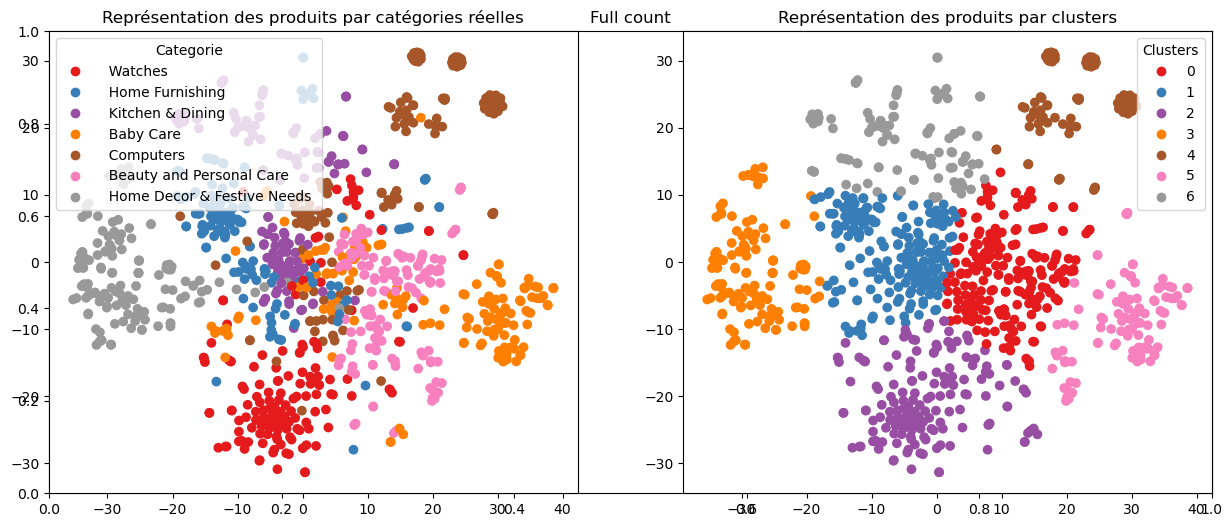

ARI :  0.3999


In [23]:
from sklearn import manifold, decomposition
from sklearn import cluster, metrics

list_ARI_PCA = []

ARI, full_ctsne, labels = ARI_tsne_pca(full_count.toarray(), 0.99)
list_ARI_PCA.append(ARI)
TSNE_visu(full_ctsne, num_cat, labels, ARI, 'Full count')

Variance cumulée : 97.0
ARI :  0.4664 time :  5.0


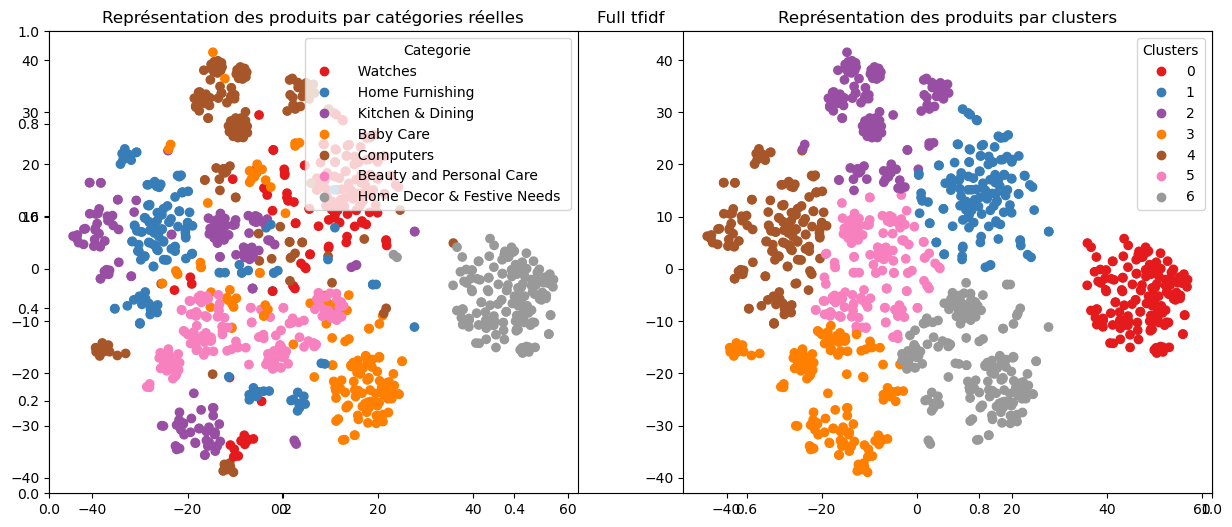

ARI :  0.4664


In [24]:
ARI, full_tftsne, labels = ARI_tsne_pca(full_tf.toarray(), 0.97)
list_ARI_PCA.append(ARI)
TSNE_visu(full_tftsne, num_cat, labels, ARI,'Full tfidf')

Variance cumulée : 97.0
ARI :  0.4572 time :  5.0


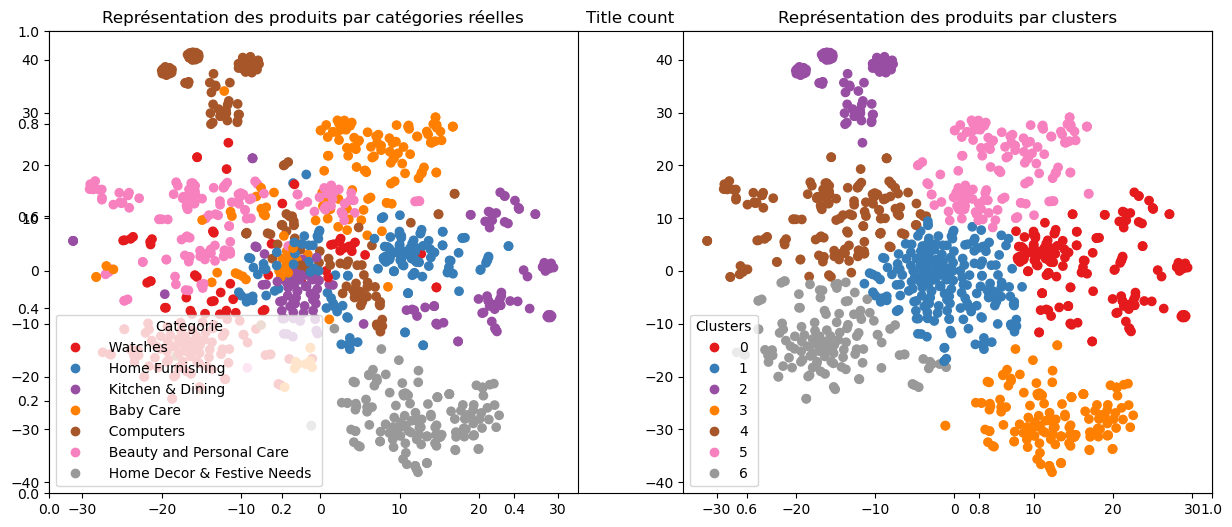

ARI :  0.4572


In [25]:
ARI, title_ctsne, labels = ARI_tsne_pca(title_count.toarray(), 0.97)
list_ARI_PCA.append(ARI)
TSNE_visu(title_ctsne, num_cat, labels, ARI, 'Title count')

Variance cumulée : 97.0
ARI :  0.5063 time :  4.0


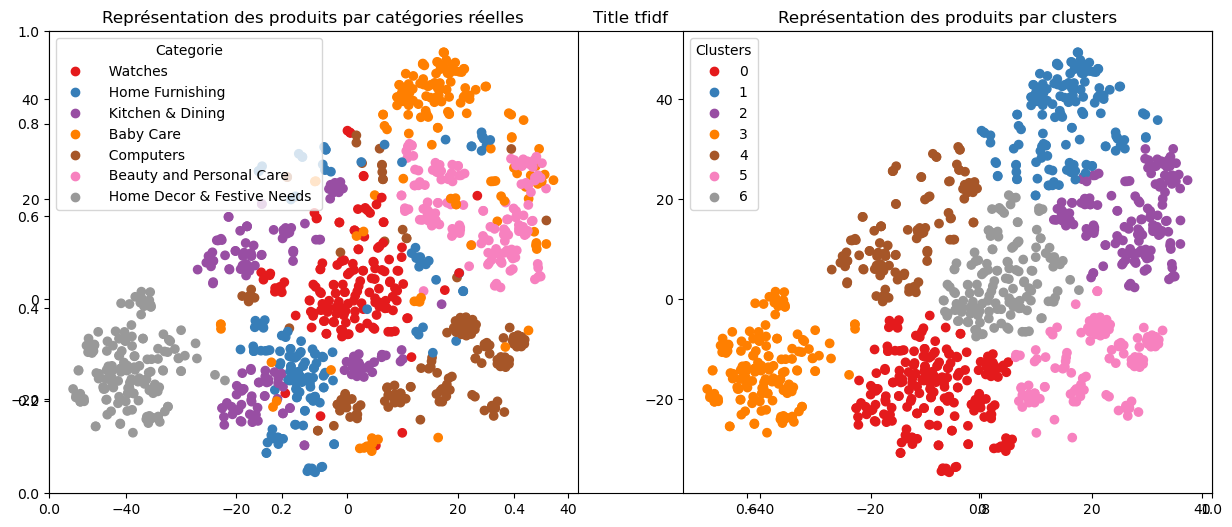

ARI :  0.5063


In [26]:
ARI, title_tftsne, labels = ARI_tsne_pca(title_tf.toarray(), 0.97)
list_ARI_PCA.append(ARI)
TSNE_visu(title_tftsne, num_cat, labels, ARI, 'Title tfidf')

In [27]:
ARI_PCA = pd.DataFrame(list_ARI_PCA).T
ARI_PCA.columns=['full_count','full_tfidf','title_count','title_tfidf']
ARI_PCA.rename({0:'PCA'}, inplace=True)
display(ARI_PCA)

,full_count,full_tfidf,title_count,title_tfidf
PCA,0.3999,0.4664,0.4572,0.5063


On a d'assez bons résultats malgré qu'on n'ait pas cherché à le maximiser. De plus, les résultats sont meilleurs avec le tf-idf qu'avec CountVectorizer. Enfin, pour le CV il n'y a pas de différence entre l'entraînement du modèle sur tous les mots on uniquement sur le titre, mais le tf-idf obtient de meilleurs résultats en prenant tout en compte.

On note tout de même que ces approches permettent déjà de voir qu'il serait possible de faire une classification à partir des données textuelles, avec des ARI entre 0.4 et 0.5.

## 2e approche : Word2Vec

On va maintenant essayer une aprpoche avec un nouveau modèle : Word2Vec. Cet algorithme analyse les phrases à l'aide d'un réseau de neurones et détecte les associations de mots, et vient ensuite représenter chaque mots par un vecteur, avec les mots souvent trouvés ensemble qui sotn donc rapprochés sur cet espace vectoriel.

In [31]:
#On importe tensorflow et les modules nécessaires au fontionnement de W2V

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

On crée une fonction qui va procéder au traitement des données, à l'entraînement du modèle, la création de la matrice d'embedding et qui enfin vient prédire les catégories de chaque produit à partir des 

In [32]:
def w2v_embedding (data) :
    
    w2v_size=400
    w2v_window=4
    w2v_min_count=1
    w2v_epochs=100
    maxlen = 15 # adapt to length of sentences
    sentences = texts['all_words'].to_list()
    sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
    
    train = data.to_list()
    train = [gensim.utils.simple_preprocess(text) for text in train]
    
    # Création et entraînement du modèle Word2Vec

    print("Build & train Word2Vec model ...")
    w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=10,
                                                workers=1) 
    w2v_model.build_vocab(train)
    w2v_model.train(train, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
    model_vectors = w2v_model.wv
    w2v_words = model_vectors.index_to_key
    print("Vocabulary size: %i" % len(w2v_words))
    print("Word2Vec trained")
    
    # Préparation des sentences (tokenization)

    print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
    num_words = len(tokenizer.word_index) + 1
    print("Number of unique words: %i" % num_words)
    
    # Création de la matrice d'embedding

    print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, w2v_size))
    i=0
    j=0
    
    for word, idx in word_index.items():
        i +=1
        if word in w2v_words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
            
    word_rate = np.round(j/i,4)
    print("Word embedding rate : ", word_rate)
    print("Embedding matrix: %s" % str(embedding_matrix.shape))
    
    # Création du modèle

    input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)

    print(embed_model.summary())
    
    return embed_model.predict(x_sentences)

### Execution du modèle

### Seulement avec le titre

In [41]:
embeddings = w2v_embedding(texts['product_name'])
embeddings.shape

Build & train Word2Vec model ...
Vocabulary size: 1947
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 1948
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (1948, 400)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 15, 400)           779200    
                                                                 
 global_average_pooling1d_3   (None, 400)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 779,200
Trainable params: 779,200
Non-trainable params: 0
_________________________________________________________________
None
33/33 [==============================] - 0

(1050, 400)

Variance cumulée : 99.0
ARI :  0.3573 time :  4.0
0.3573


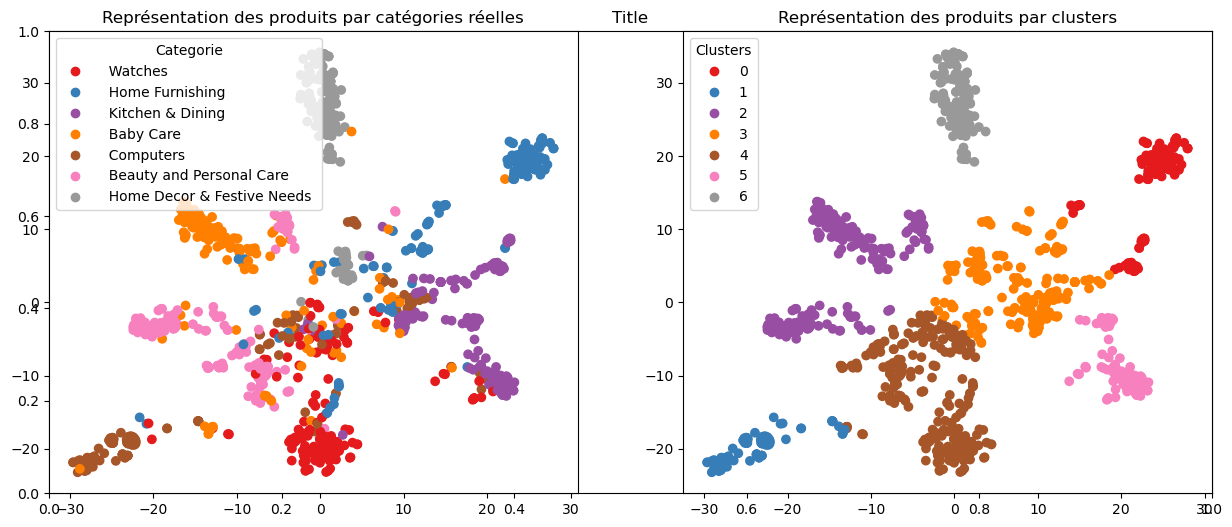

ARI :  0.3573


In [42]:
ARI, X_tsne, labels = ARI_tsne_pca(embeddings, 0.99)
print(ARI)
TSNE_visu(X_tsne, num_cat, labels, ARI, 'Title')

### Avec tous les mots 

In [43]:
embeddings = w2v_embedding(texts['all_words'])
embeddings.shape

Build & train Word2Vec model ...
Vocabulary size: 4662
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 4663
Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4663, 400)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 15)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 15, 400)           1865200   
                                                                 
 global_average_pooling1d_4   (None, 400)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,865,200
Trainable params: 1,865,200
Non-trainable params: 0
_________________________________________________________________
None
33/33 [==============================]

(1050, 400)

Variance cumulée : 99.0
ARI :  0.3014 time :  4.0
0.3014


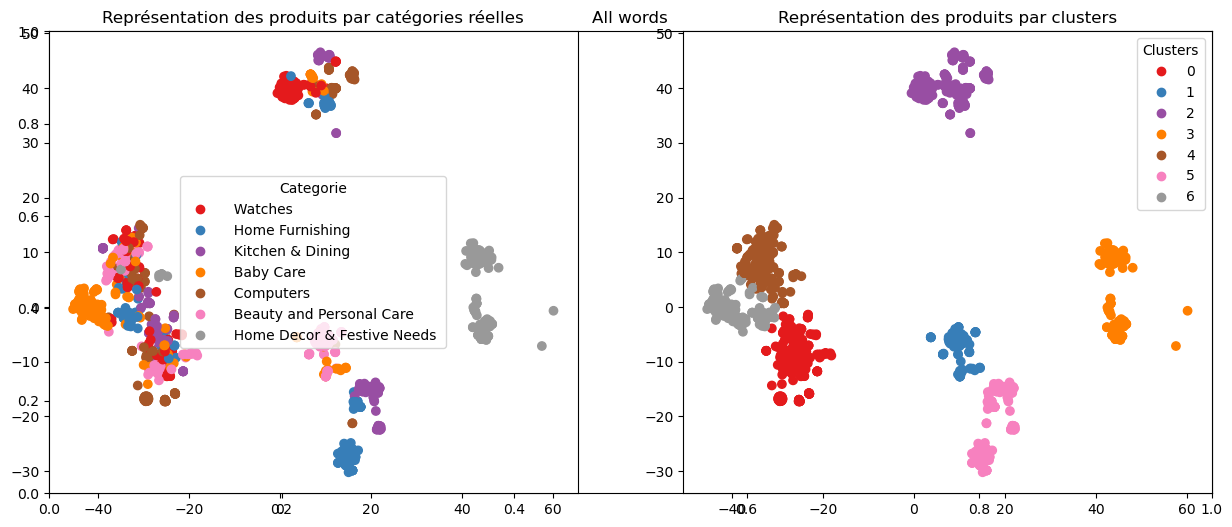

ARI :  0.3014


In [44]:
ARI, X_tsne, labels = ARI_tsne_pca(embeddings, 0.99)
print(ARI)
TSNE_visu(X_tsne, num_cat, labels, ARI, 'All words')

On voit cette fois encore qu'on obtient de meilleurs résultats en entraînant le modèle sur uniquement les mots du titre et non l'ensemble des mots. Les résultats sont cependant généralement plus bas qu'avec nos deux première méthodes.

## BERT

BERT est une nouvelle fois un modèle qui utilise les réseaux de neurones, mais à la différence de Word2Vec, où on entraîne le modèle uniquement sur nos données, les modèles BERT sont pré-entraînés sur de volumineux datasets, et permettent donc une meilleure reconnaissance et de meilleurs résultats.

In [50]:
# Bert
import os
import transformers
from transformers import AutoTokenizer

os.environ["TF_KERAS"]='1'

In [51]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred, verbose=0)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### Hugging Face 

Le premier modèle qu'on va utiliser avec BERT est Hugging Face, en prenant un modèle pré-entraîné assez général 'bert_base_uncased'.

In [55]:
def HF_embedding(data, title='') : 
    # On garde les mêmes paramètres que précédemment
    max_length = 40
    batch_size = 10

    # On utiliser un modèle pré-entrainé
    model_type = "bert-base-uncased"
    model = transformers.TFAutoModel.from_pretrained(model_type)
    sentences = data.to_list()
    
    features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')
    
    ARI, X_tsne, labels = ARI_tsne_pca(features_bert, 0.99)
    TSNE_visu(X_tsne, num_cat, labels, ARI, title)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


temps traitement :  23.0
Variance cumulée : 99.0
ARI :  0.4162 time :  5.0


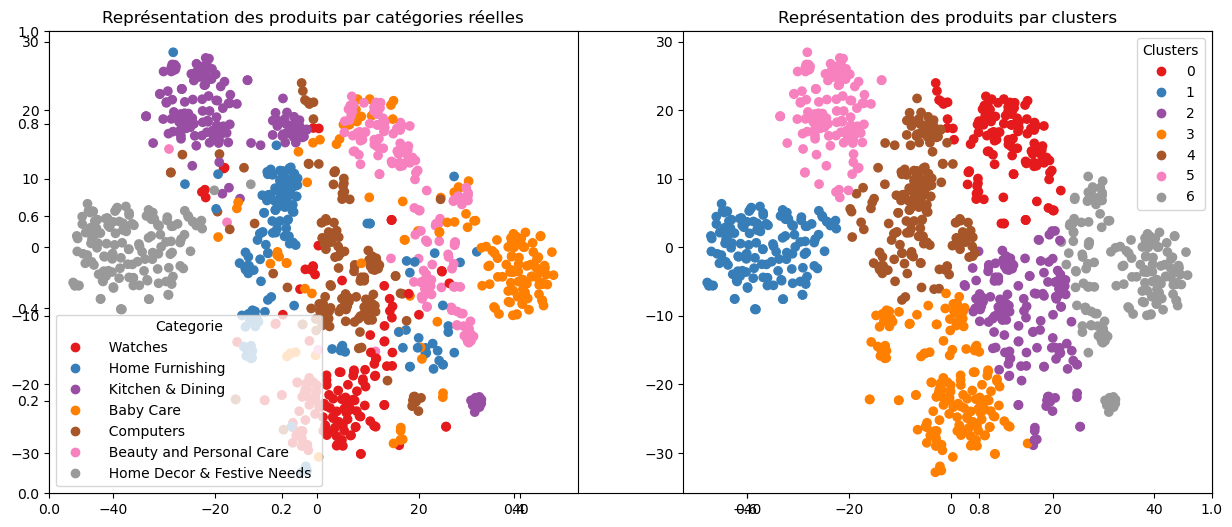

ARI :  0.4162


In [53]:
HF_embedding(texts['all_words'])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


temps traitement :  19.0
Variance cumulée : 99.0
ARI :  0.5565 time :  5.0


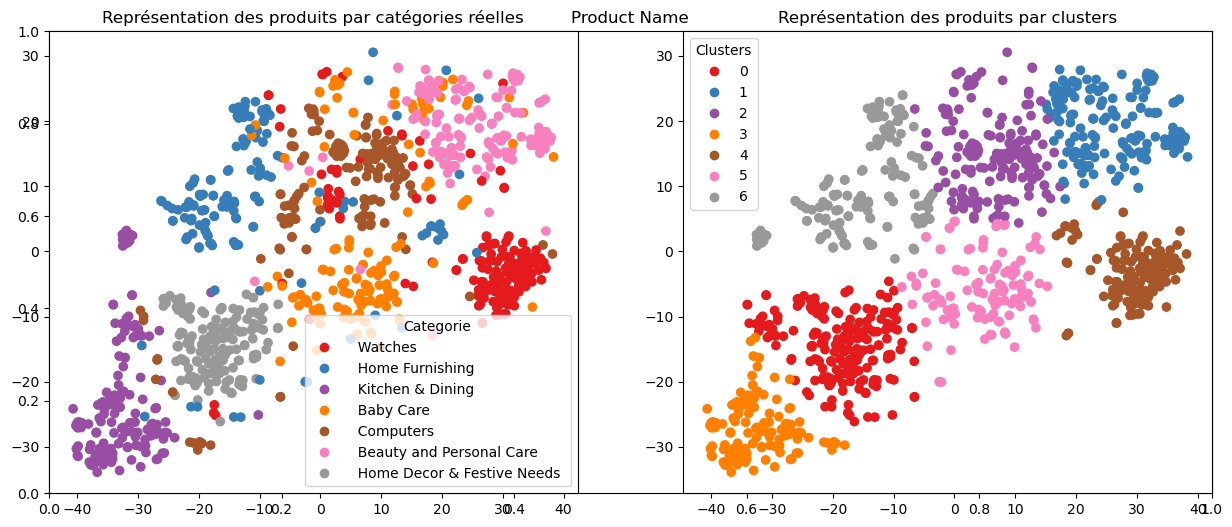

ARI :  0.5565


In [60]:
HF_embedding(texts['product_name'], title = 'Product Name')

### BERT hub Tensorflow


On peut également utiliser des modèles via le module tensorflow, qui est généralement plus répandu.

In [57]:
import tensorflow_hub as hub

In [61]:
def TF_embedding(data, title='') : 
    
    model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    bert_layer = hub.KerasLayer(model_url, trainable=True)
    
    sentences = data.to_list()
    
    max_length = 70
    batch_size = 10
    model_type = 'bert-base-uncased'
    model = bert_layer

    features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')
    
    ARI, X_tsne, labels = ARI_tsne_pca(features_bert, 0.99)
    TSNE_visu(X_tsne, num_cat, labels, ARI, title)

temps traitement :  72.0
Variance cumulée : 99.0
ARI :  0.5704 time :  5.0


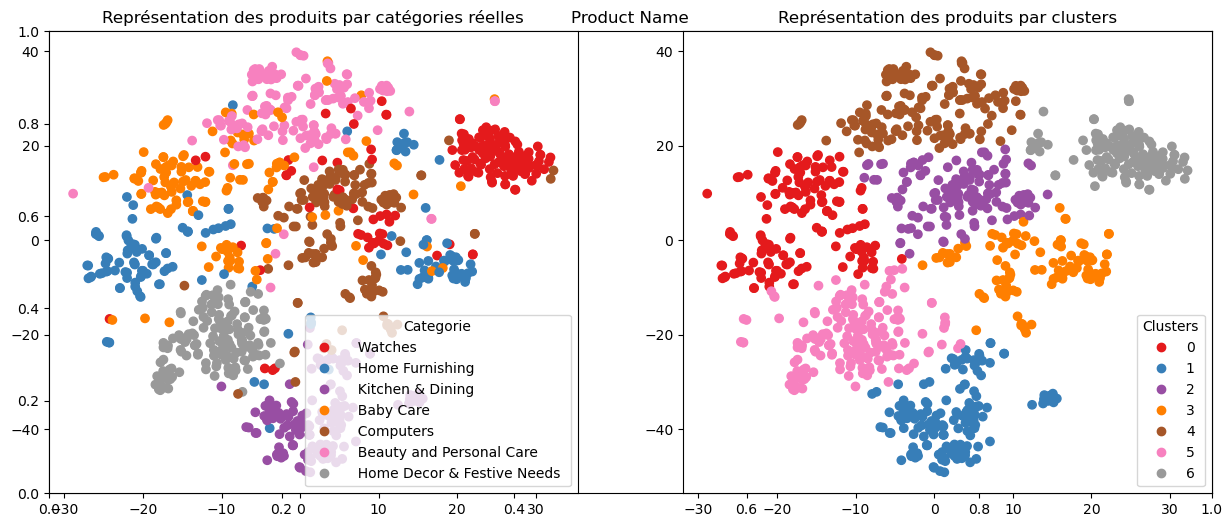

ARI :  0.5704


In [62]:
TF_embedding(texts['product_name'], title='Product Name')

## USE

Universal Sentence Encoder, ou USE est encore un modèle qui sert à analyser des features textes. On utilise une nouvelle fois un modèle pré-entraîné pour traiter nos données, mais le fonctionnement de USE est légèrement différent du modèle BERT qu'on vient juste de voir.

In [63]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

batch_size = 15
sentences = texts['product_name'].to_list()

Variance cumulée : 99.0
ARI :  0.6373 time :  4.0


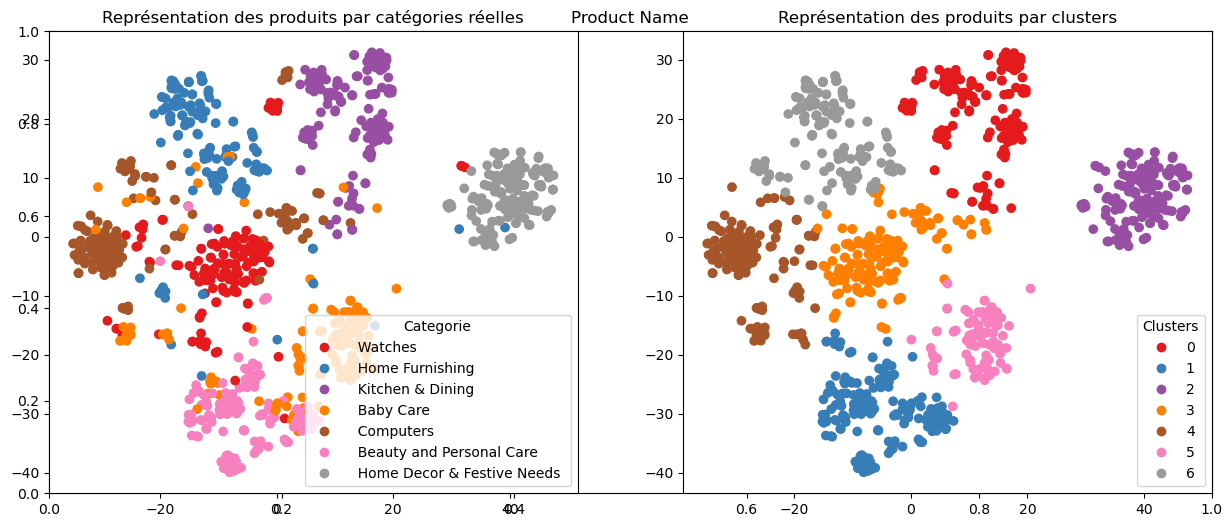

ARI :  0.6373


In [64]:
features_USE = feature_USE_fct(sentences, batch_size)

ARI, X_tsne, labels = ARI_tsne_pca(features_USE, 0.99)
TSNE_visu(X_tsne,num_cat, labels, ARI, title='Product Name')

On voit ici que USE donne les meilleurs résultats jusqu'ici, et permet définitivement de valider qu'il est possible de créer un système de classification à partir des données textuelles trouvées dans chaque annonce.

On va maintenant s'intéresser au traitement des images fournies.